In [ ]:
%cd drive/MyDrive/projects/toxicity-multiclass
!ls

/content/drive/MyDrive/projects/toxicity-multiclass
chapters  models     pyproject.toml  results  src
data	  notebooks  README.md	     scripts


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.insert(0, '.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

In [ ]:
from src.toxicity.models.xgboost_multilabel import (
    TOX21_ASSAYS
)

In [ ]:
from src.toxicity.models.mlp_baseline import MultiLabelMLP


In [ ]:
print(" Loading data...\n")


# DataFrames (after featurization)
train_df = pd.read_csv('data/processed/train_clean_featurized.csv') # exists only to check the shape
val_df = pd.read_csv('data/processed/val_clean_featurized.csv')
test_df = pd.read_csv('data/processed/test_clean_featurized.csv')

print(f"DataFrames loaded:")
print(f"   Train: {len(train_df):,} molecules")
print(f"   Val:   {len(val_df):,} molecules")
print(f"   Test:  {len(test_df):,} molecules")

# Load fingerprints (features)
X_train = np.load('data/features/X_train_morgan.npy')
X_val = np.load('data/features/X_val_morgan.npy')
X_test = np.load('data/features/X_test_morgan.npy')

print(f"\nFingerprints loaded:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Test:  {X_test.shape}")

# Extract labels
y_train = train_df[TOX21_ASSAYS].values.astype(float)
y_val = val_df[TOX21_ASSAYS].values.astype(float)
y_test = test_df[TOX21_ASSAYS].values.astype(float)

print(f"\nLabels extracted:")
print(f"   Train: {y_train.shape}")
print(f"   Val:   {y_val.shape}")
print(f"   Test:  {y_test.shape}")

print(f"\n Data loaded successfully!")

 Loading data...

DataFrames loaded:
   Train: 6,162 molecules
   Val:   777 molecules
   Test:  778 molecules

Fingerprints loaded:
   Train: (6162, 2048)
   Val:   (777, 2048)
   Test:  (778, 2048)

Labels extracted:
   Train: (6162, 12)
   Val:   (777, 12)
   Test:  (778, 12)

 Data loaded successfully!


In [ ]:
print("\n" + "="*80)
print("TRAINING MLP BASELINE")
print("="*80)

mlp_model = MultiLabelMLP(
    task_names=TOX21_ASSAYS,
    hidden_layers=(512, 256),
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,   # uses internal split from TRAIN only
    verbose=1
)

start_time = time.time()
mlp_model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"\n  MLP training time: {train_time:.1f}s ({train_time/60:.1f} min)")


TRAINING MLP BASELINE
 MultiLabelMLP initialized
   Tasks: 12
   Architecture (typical): 2048 → 512 → 256 → 1

TRAINING MULTI-LABEL MLP

[1/12] NR-AR
------------------------------------------------------------
   Labeled samples: 5,705 / 6,162
   Positive: 255 (4.5%) | Negative: 5,450
     sample_weight not supported; training without it.
    Trained: n_iter=14 | loss=0.0040

[2/12] NR-AR-LBD
------------------------------------------------------------
   Labeled samples: 5,332 / 6,162
   Positive: 191 (3.6%) | Negative: 5,141
     sample_weight not supported; training without it.
    Trained: n_iter=12 | loss=0.0015

[3/12] NR-AhR
------------------------------------------------------------
   Labeled samples: 5,141 / 6,162
   Positive: 609 (11.8%) | Negative: 4,532
     sample_weight not supported; training without it.
    Trained: n_iter=13 | loss=0.0044

[4/12] NR-Aromatase
------------------------------------------------------------
   Labeled samples: 4,599 / 6,162
   Positive:

due to library constraints class weighting couldnt be applied and since it's a baseline model i didnt try to inforce it

In [ ]:
print("\nEvaluating on validation set...\n")
val_results = mlp_model.evaluate(X_val, y_val, threshold=0.5)

print("VAL summary:", val_results["summary"])

print("\nEvaluating on test set...\n")
test_results = mlp_model.evaluate(X_test, y_test, threshold=0.5)

print("TEST summary:", test_results["summary"])


Evaluating on validation set...

VAL summary: {'macro_roc_auc': 0.7358798613209204, 'macro_pr_auc': 0.41661906054800313, 'macro_precision': 0.6583994443586973, 'macro_recall': 0.2651636099873815, 'macro_f1': 0.3667960590668304, 'n_tasks_trained': 12.0}

Evaluating on test set...

TEST summary: {'macro_roc_auc': 0.7504996713885669, 'macro_pr_auc': 0.42303813255223316, 'macro_precision': 0.6281111716696611, 'macro_recall': 0.2784770819149886, 'macro_f1': 0.3595903721578197, 'n_tasks_trained': 12.0}


works better with lowwer threshold (0.2 => f1 score : 0.4)


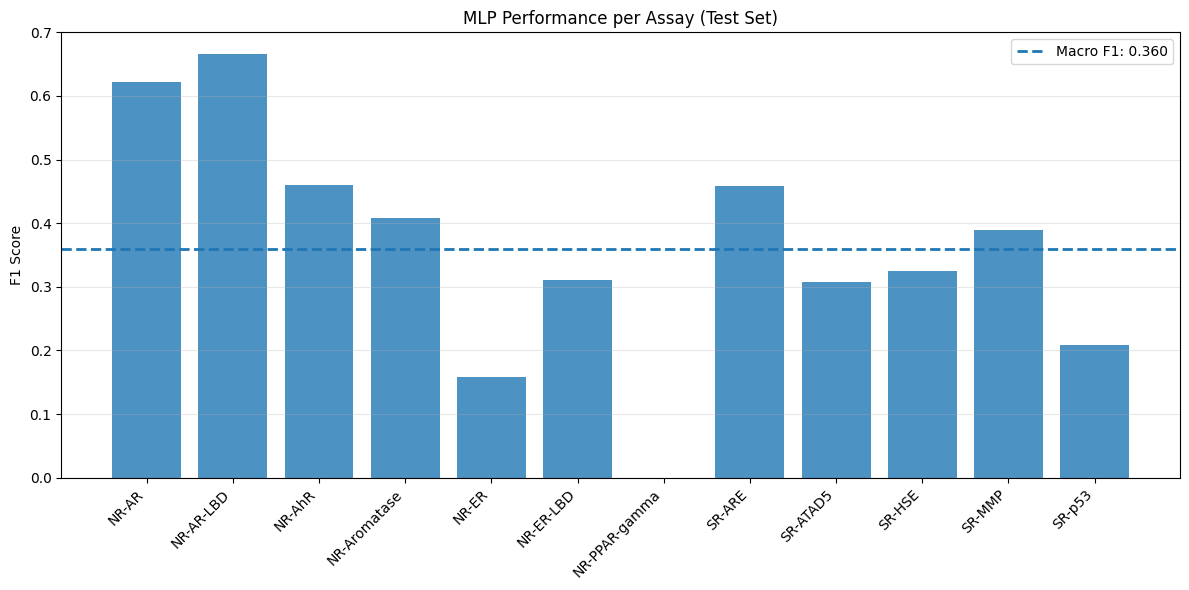

Saved: results/figures/mlp_performance.png


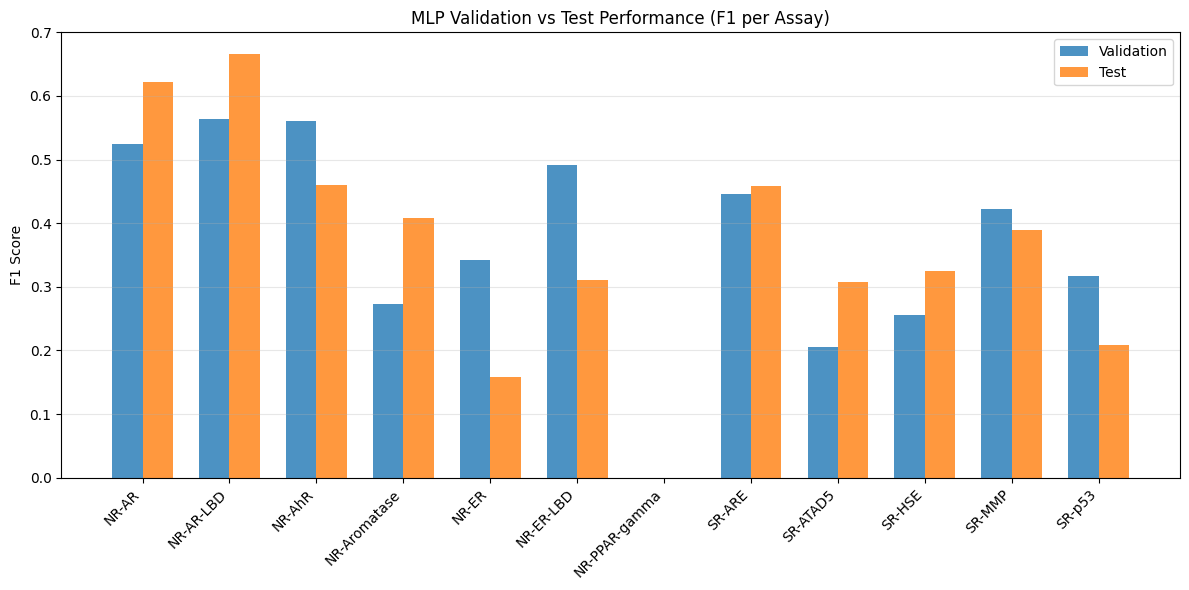

Saved: results/figures/mlp_val_vs_test.png


In [ ]:
tasks = TOX21_ASSAYS

test_f1_scores = [test_results["per_task"][t]["f1"] for t in tasks]
macro_f1_test = test_results["summary"]["macro_f1"]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(tasks)), test_f1_scores, alpha=0.8)
ax.axhline(y=macro_f1_test, linestyle="--", linewidth=2, label=f"Macro F1: {macro_f1_test:.3f}")
ax.set_xticks(range(len(tasks)))
ax.set_xticklabels(tasks, rotation=45, ha="right")
ax.set_ylabel("F1 Score")
ax.set_title("MLP Performance per Assay (Test Set)")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("results/figures/mlp_performance.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: results/figures/mlp_performance.png")

# Val vs Test F1
val_f1_scores = [val_results["per_task"][t]["f1"] for t in tasks]

x = np.arange(len(tasks))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, val_f1_scores, width, label="Validation", alpha=0.8)
ax.bar(x + width/2, test_f1_scores, width, label="Test", alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(tasks, rotation=45, ha="right")
ax.set_ylabel("F1 Score")
ax.set_title("MLP Validation vs Test Performance (F1 per Assay)")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("results/figures/mlp_val_vs_test.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: results/figures/mlp_val_vs_test.png")

In [ ]:
mlp_model.save("models/mlp_baseline")

results_summary = {
    "model": "MLP Multi-Label Baseline (Binary Relevance)",
    "training_time_seconds": float(train_time),
    "threshold": 0.5,
    "validation": {
        **{k: float(v) if v is not None else None for k, v in val_results["summary"].items()},
    },
    "test": {
        **{k: float(v) if v is not None else None for k, v in test_results["summary"].items()},
        "per_task": {}
    },
}

for task in tasks:
    m = test_results["per_task"][task]
    results_summary["test"]["per_task"][task] = {
        "f1": float(m["f1"]) if not np.isnan(m["f1"]) else float("nan"),
        "precision": float(m["precision"]) if not np.isnan(m["precision"]) else float("nan"),
        "recall": float(m["recall"]) if not np.isnan(m["recall"]) else float("nan"),
        "roc_auc": float(m["roc_auc"]) if not np.isnan(m["roc_auc"]) else float("nan"),
        "pr_auc": float(m["pr_auc"]) if not np.isnan(m["pr_auc"]) else float("nan"),
        "n": int(m["n"]),
    }

with open("results/mlp_results.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("Saved: models/mlp_baseline")
print("Saved: results/mlp_results.json")


 Saved to: models/mlp_baseline
Saved: models/mlp_baseline
Saved: results/mlp_results.json


In [ ]:
print("\n" + "="*80)
print("FINAL RESULTS - MLP TEST SET")
print("="*80)

print("\nOverall Performance:")
print(f"  Macro F1:        {test_results['summary']['macro_f1']:.4f}")
print(f"  Macro Precision: {test_results['summary']['macro_precision']:.4f}")
print(f"  Macro Recall:    {test_results['summary']['macro_recall']:.4f}")
print(f"  Macro ROC-AUC:   {test_results['summary']['macro_roc_auc']:.4f}")
print(f"  Macro PR-AUC:    {test_results['summary']['macro_pr_auc']:.4f}")

sorted_tasks_best = sorted(
    [(t, test_results["per_task"][t]["f1"]) for t in tasks],
    key=lambda x: (np.nan_to_num(x[1], nan=-1.0)),
    reverse=True
)[:3]

sorted_tasks_worst = sorted(
    [(t, test_results["per_task"][t]["f1"]) for t in tasks],
    key=lambda x: (np.nan_to_num(x[1], nan=1e9))
)[:3]

print("\nBest Performing Assays:")
for t, f1v in sorted_tasks_best:
    print(f"  {t:<12} F1: {('nan' if np.isnan(f1v) else f'{f1v:.4f}')}")

print("\nMost Challenging Assays:")
for t, f1v in sorted_tasks_worst:
    print(f"  {t:<12} F1: {('nan' if np.isnan(f1v) else f'{f1v:.4f}')}")

print("\n" + "="*80)


FINAL RESULTS - MLP TEST SET

Overall Performance:
  Macro F1:        0.3596
  Macro Precision: 0.6281
  Macro Recall:    0.2785
  Macro ROC-AUC:   0.7505
  Macro PR-AUC:    0.4230

Best Performing Assays:
  NR-AR-LBD    F1: 0.6667
  NR-AR        F1: 0.6222
  NR-AhR       F1: 0.4602

Most Challenging Assays:
  NR-PPAR-gamma F1: 0.0000
  NR-ER        F1: 0.1584
  SR-p53       F1: 0.2083

